![](https://images.pexels.com/photos/1300526/pexels-photo-1300526.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=750&w=1260)

# Simulating Non-linear Systems with Control Inputs

Kevin J. Walchko, Phd

20 Nov 2019

---

Most matematical solvers only look at unforced solutions. But what if you want to input a control signal? 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import pi, sin, sqrt

%matplotlib inline

In [2]:
def clamp(x, a, b):
    x = x if x>=a else a
    x = x if x<=b else b
    return x

In [3]:
def crit(K,B,M):
    """
    https://web.njit.edu/~kenahn/11spring/phys106/Lecture/L23.pdf
    K: spring const
    B: dampenig coeff
    M: mass
    """
    w = sqrt(K/M)
    D=sqrt(w**2-(B/(2*M))**2)
    print("Dampening System:",D)
    print("critical dampening coeff:",2*sqrt(K*M))
    
crit(5,10,5)

Dampening System: 0.0
critical dampening coeff: 10.0


# Vanderpol Oscillator

Now this doesn't use a controls input, but I know what the output plot should look like, so it is just a test of `pyrk` to ensure it is working correctly.

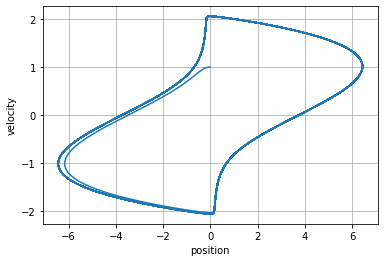

In [4]:
from pyrk import RK4

def vanderpol(t, xi, u):
        dx, x = xi
        mu = 4.0 # damping

        ddx = mu*(1-x**2)*dx-x
        dx = dx

        return np.array([ddx, dx])

rk = RK4(vanderpol)
t, y = rk.solve(np.array([0, 1]), .01, 200)

y1 = [x[0] for x in y]
y2 = [x[1] for x in y]

plt.plot(y1, y2)
plt.ylabel('velocity')
plt.xlabel('position')
plt.grid(True)
plt.show()

# Simple Mass-Spring-Dampener

Here we set a goal position for the MSD and force it to that position

In [5]:
def msd(t, xi, u):
    """
    t: time
    xi: states
    u: control signal
    """
    dx, x = xi
    
    m = 5  # mass
    k = 5  # spring const
    d = 4  # dampener coeff
    
    ddx = (u - d*dx - k*x)/m
    dx = dx
    
    return np.array([ddx, dx])

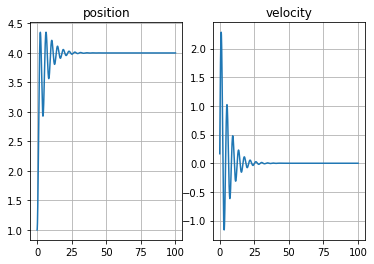

In [6]:
rk = RK4(msd)
y = np.array([0,1])
t = 0.0
step = 0.05
ierr = 0
last_err = 0

yi = []
ti = []

goal = 4

for i in range(2000):
    err = goal - y[1]
    ierr += err*step
    derr = (err - last_err)/step
    u = 5*err + 4*ierr + 0.1*derr
    
    y = rk.step(y,u,t,step)
    t += step
    
    ti.append(t)
    yi.append(y)

v = [x[0] for x in yi] # velocity
p = [x[1] for x in yi] # position

plt.subplot(1,2,1)
plt.plot(ti,p)
plt.title('position')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(ti,v)
plt.title('velocity')
plt.grid(True)

plt.show()

# Scipy

Basically do the same with `scipy` to verify we get the same result as RK45 above.

In [7]:
from scipy.integrate import odeint

In [8]:
def msd2(xi, t, u):
    """
    t: time
    xi: states
    u: control signal
    """
    dx, x = xi
    
    m = 5  # mass
    k = 5  # spring const
    d = 4  # dampener coeff
    
    ddx = (u - d*dx - k*x)/m
    dx = dx
    
    return [ddx, dx]

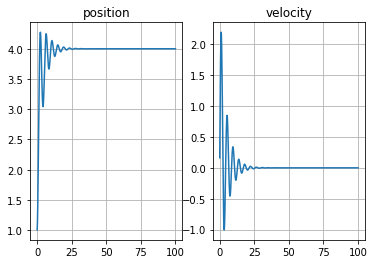

In [9]:
y = [0,1]
t = 0.0
step = 1/20
ierr = 0
last_err = 0

yi = []
ti = []

goal = 4

for i in range(2000):
    err = goal - y[1]
    ierr += err*step
    derr = (err - last_err)/step
    u = 5*err + 4*ierr + 0.1*derr
    
    yy = odeint(msd2, y, [t, t+step], args=(u, ))
    t += step
    
    ti.append(t)
    yi.append(yy[1,:])
    
    y = yy[-1]

v = [x[0] for x in yi] # velocity
p = [x[1] for x in yi] # position

plt.subplot(1,2,1)
plt.plot(ti,p)
plt.title('position')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(ti,v)
plt.title('velocity')
plt.grid(True)

plt.show()

# Conclusion

So I have shown how to simulate EOM with a controls input using python. Both `scipy` and `pyrk` produce similar results.